In [1]:
import numpy as np
import os
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from matplotlib import collections as mc
from PIL import Image
from io import BytesIO
from trajectory_visualizer import TrajectoryVisualizer
from StrokeTrajDataset import StrokeTrajDataset
from SimBetaVAE import SimBetaVAE
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import os
import wandb
from sklearn.manifold import TSNE
import plotly.express as px

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'

In [2]:
with open("simulated_stroke_data/strokes.npy", "rb") as f:
    strokes = np.load(f)
with open("simulated_stroke_data/trajectories.npy", "rb") as f:
    trajectories = np.load(f)

strokes = torch.from_numpy(strokes).float()
trajectories = torch.from_numpy(trajectories).float()

In [3]:
tv = TrajectoryVisualizer(-1, 1, -1, 1, 0, 1)

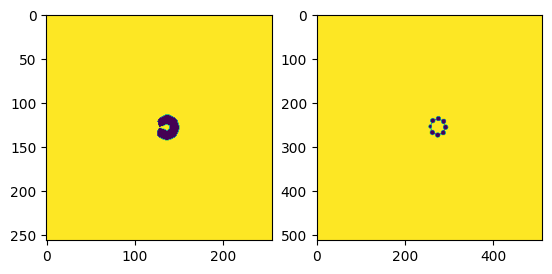

In [4]:
idx = 208
_, axs = plt.subplots(1,2)
axs[0].imshow(strokes[idx])
axs[1].imshow(tv.visualize_trajectory(trajectories[idx]))

In [ ]:
wandb.init(project="diverse-strokes", mode="online")

max_capacity = 0
beta = 0.001
num_epochs = 600
epochs_per_save = 50
schedule = "constant"
duration = 100

wandb.config = {
    "epochs": num_epochs,
    "beta": beta,
    "max_capacity": max_capacity,
    "schedule": schedule,
    "duration": duration
}

def get_beta(step):
    # if schedule="constant", always return beta
    # if schedule="monotonic", increase linearly to beta until duration, at which it stays constant
    # if schedule="cyclical", increase from 0 to beta over duration steps, stay constant for duration more steps, and repeat
    if schedule == "constant":
        return beta
    elif schedule == "monotonic":
        return min(beta * step/duration, beta)
    elif schedule == "cyclical":
        step = step % (2*duration)
        return min(beta * step/duration, beta)
    else:
        raise ValueError("invalid schedule")

resize64 = torchvision.transforms.Resize((64, 64), antialias=True)
resize512 = torchvision.transforms.Resize((512, 512), antialias=True)
resized_strokes = resize64(strokes)

model = SimBetaVAE()
model.to(device)
optimizer = optim.Adam(model.parameters())

train_test_split = int(0.8 * len(resized_strokes))
from sklearn.utils import shuffle
s, t = shuffle(resized_strokes, trajectories, random_state=0)
train = s[:train_test_split], t[:train_test_split]
test = s[train_test_split:], t[train_test_split:]

train_dataset = StrokeTrajDataset(*train)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataset = StrokeTrajDataset(*test)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

def plot_embeddings(model, data):
    # data: [[class, strokes, trajectories], [class, strokes, trajectories], ...] where each subarray is a different class
    encodings = []
    classes = []
    for (c, strokes, trajectories) in data:
        dataset = StrokeTrajDataset(strokes, trajectories)
        dataloader = DataLoader(dataset, batch_size=16, shuffle=False)
        classes += [c for _ in range(len(dataset))]
        for (stroke, trajectory) in dataloader:
            stroke = stroke.to(device)
            trajectory = trajectory.to(device)
            mean, _ = model.encode(stroke, trajectory)
            encodings.append(mean)
    encodings = torch.concat(encodings, axis=0) # n x 5
    encodings = encodings.cpu().detach()
    reduced_encodings = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=10).fit_transform(encodings)
    fig = px.scatter(x=reduced_encodings[:,0], y=reduced_encodings[:,1], color=classes)
    return fig

def validation(model, dataloader):
    model.eval()
    total_loss = 0
    originals = []
    decoder_outputs = []
    
    for (stroke,trajectory) in dataloader:
        batch_size = len(stroke)
        stroke = stroke.to(device)
        trajectory = trajectory.to(device)
        args = model(stroke, trajectory)
        loss = model.reconstruction_loss(args)
        total_loss += loss * batch_size
        
        for i in range(batch_size):
            stroke_dec = args[0][0][i].squeeze(0).cpu().detach()
            traj_dec = args[0][1][i].cpu().detach()
            decoder_outputs.append((stroke_dec, traj_dec))
            stroke = args[1][0][i].squeeze(0).cpu().detach()
            traj = args[1][1][i].cpu().detach()
            originals.append((stroke, traj))

    avg_loss = total_loss / len(dataloader.dataset)
    model.train()
    return avg_loss, decoder_outputs, originals

fig = plot_embeddings(
    model,
    [
        ["bezier", resized_strokes[:200], trajectories[:200]],
        ["circle", resized_strokes[200:], trajectories[200:]]
    ]
)
wandb.log({"embeddings": fig})

for epoch in range(num_epochs):
    cur_beta = get_beta(epoch)
    capacity = epoch / num_epochs * max_capacity
    total_loss = 0
    for (i, (stroke, trajectory)) in enumerate(train_dataloader):
        batch_size = len(stroke)
        stroke = stroke.to(device)
        trajectory = trajectory.to(device)
        args = model(stroke, trajectory)
        loss = model.loss(args, cur_beta, capacity)
        
        total_loss += loss * batch_size
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i == 0 and epoch%epochs_per_save == epochs_per_save-1:
            output_dir = f"training_outputs/epoch{epoch}/train"
            os.makedirs(output_dir, exist_ok=True)
            for i in range(batch_size):
                stroke_dec = args[0][0][i].squeeze(0).cpu().detach()
                stroke_dec_img = resize512(stroke_dec.unsqueeze(0).unsqueeze(0))
                traj_dec = args[0][1][i].cpu().detach()
                traj_dec_img = tv.visualize_trajectory(traj_dec).float()
                stroke = args[1][0][i].squeeze(0).cpu().detach()
                stroke_img = resize512(stroke.unsqueeze(0).unsqueeze(0))
                traj = args[1][1][i].cpu().detach()
                traj_img =  tv.visualize_trajectory(traj).float()

                images = [
                    wandb.Image(stroke_dec_img, caption='decoded stroke intensities'),
                    wandb.Image(stroke_img, caption='original stroke intensities'),
                    wandb.Image(traj_dec_img, caption='decoded trajectory'),
                    wandb.Image(traj_img, caption='original trajectory')
                ]
                wandb.log({"training outputs": images})
                # plt.imsave(f"{output_dir}/{i}-decoded.png", stroke_dec)
                # plt.imsave(f"{output_dir}/{i}-original.png", stroke)
                # plt.imsave(f"{output_dir}/{i}-traj_decoded.png", tv.visualize_trajectory(traj_dec))
                # plt.imsave(f"{output_dir}/{i}-traj_original.png", tv.visualize_trajectory(traj))
    
    train_loss = total_loss / len(train_dataset)
    val_loss, decoded_list, original_list = validation(model, val_dataloader)
    wandb.log({
        'epoch': epoch,
        'capacity': capacity,
        'cur_beta': cur_beta,
        'train_loss': train_loss,
        'val_loss': val_loss
    })

    if epoch%epochs_per_save == epochs_per_save-1:
        output_dir = f"training_outputs/epoch{epoch}/val"
        os.makedirs(output_dir, exist_ok=True)
        for i in range(len(decoded_list)):
            stroke_dec, traj_dec = decoded_list[i][0], decoded_list[i][1]
            stroke, traj = original_list[i][0], original_list[i][1]
            stroke_dec_img = resize512(stroke_dec.unsqueeze(0).unsqueeze(0))
            traj_dec_img = tv.visualize_trajectory(traj_dec).float()
            stroke_img = resize512(stroke.unsqueeze(0).unsqueeze(0))
            traj_img =  tv.visualize_trajectory(traj).float()

            images = [
                wandb.Image(stroke_dec_img, caption='decoded stroke intensities'),
                wandb.Image(stroke_img, caption='original stroke intensities'),
                wandb.Image(traj_dec_img, caption='decoded trajectory'),
                wandb.Image(traj_img, caption='original trajectory')
            ]
            wandb.log({"validation outputs": images})
            # plt.imsave(f"{output_dir}/{i}-decoded.png", stroke_dec)
            # plt.imsave(f"{output_dir}/{i}-original.png", stroke)
            # plt.imsave(f"{output_dir}/{i}-traj_decoded.png", tv.visualize_trajectory(traj_dec))
            # plt.imsave(f"{output_dir}/{i}-traj_original.png", tv.visualize_trajectory(traj))
        fig = plot_embeddings(
            model,
            [
                ["bezier", resized_strokes[:200], trajectories[:200]],
                ["circle", resized_strokes[200:], trajectories[200:]]
            ]
        )
        wandb.log({"embeddings": fig})
    
    print(f"Epoch {epoch}: Train loss={train_loss}, Validation loss={val_loss}")

torch.save(model.state_dict(), "model.pt")

In [6]:
%%capture
model = SimBetaVAE()
model.load_state_dict(torch.load("model.pt"))
model.to(device)

In [7]:
# Decoder self-improvement
from self_improvement import evaluate_consistency
print(evaluate_consistency(model))

tensor(0.0009)


In [ ]:
_, s, t = model.sample_latent(4)
_, axs = plt.subplots(4, 2)
for i in range(4):
    axs[i][0].imshow(s[i].squeeze(0).cpu().detach())
    axs[i][1].imshow(tv.visualize_trajectory(t[i].cpu().detach()))

In [9]:
def no_gap_plot(data): # https://stackoverflow.com/questions/42675864/how-to-remove-gaps-between-image-subplots
    # data: N x M x individual image
    N = len(data)
    M = len(data[0])
    heights = [50 for a in data]
    widths = [50 for a in data[0]]
    
    fig_width = 8.  # inches
    fig_height = fig_width * sum(heights) / sum(widths)

    f, axarr = plt.subplots(N,M, figsize=(fig_width, fig_height), gridspec_kw={'height_ratios':heights})

    for i in range(N):
        for j in range(M):
            axarr[i, j].imshow(data[i][j])
            axarr[i, j].axis('off')
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()

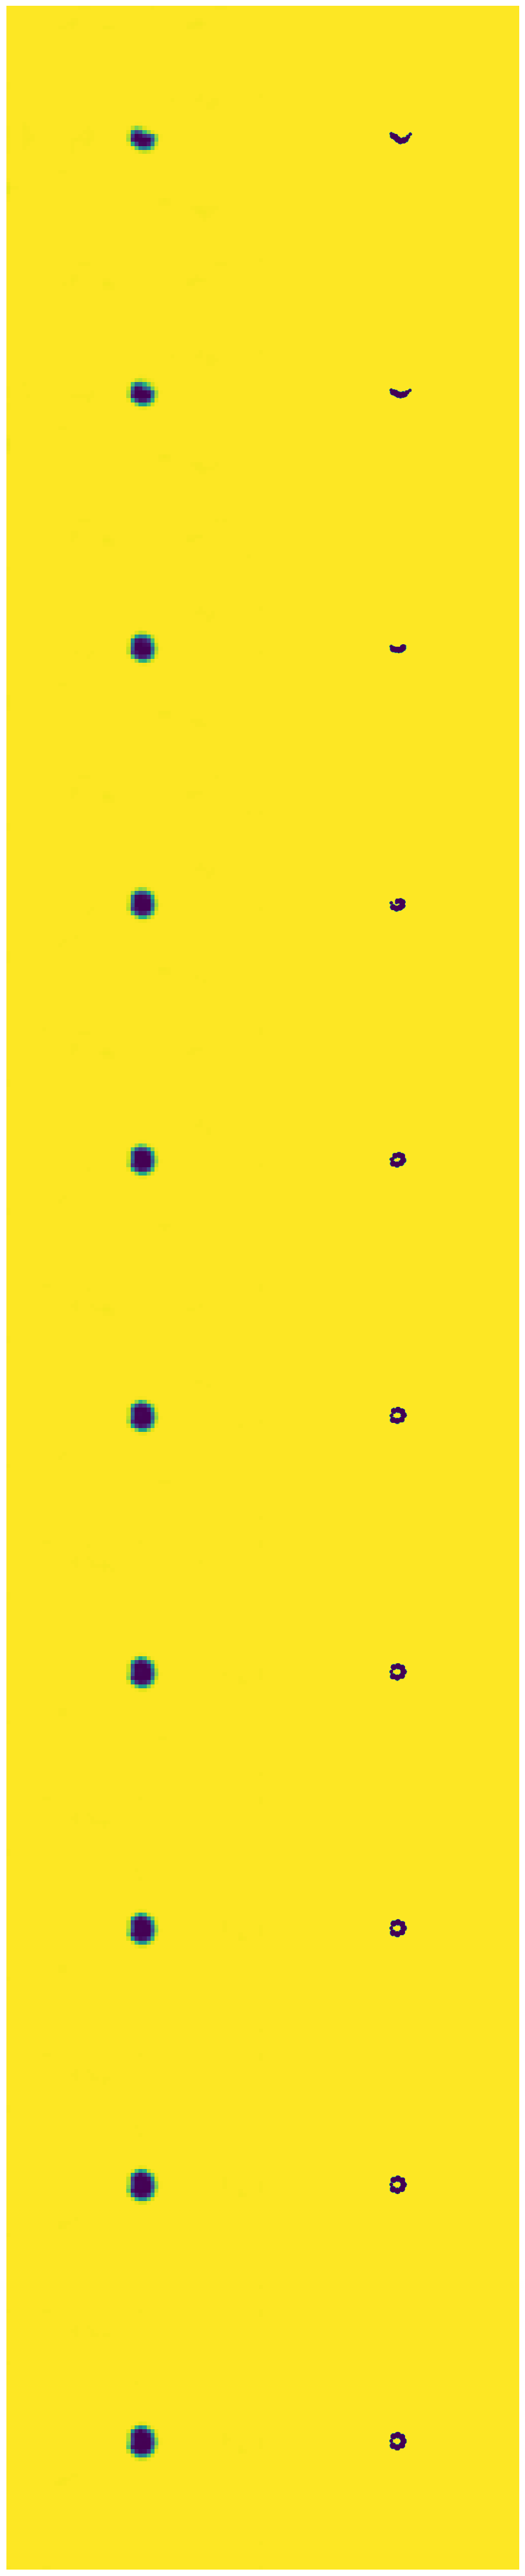

In [10]:
# Interpolating between strokes
def interpolate(idx0, idx1):
    s = resize64(strokes)
    t = trajectories
    s0 = s[idx0].unsqueeze(0).unsqueeze(0).to(device)
    t0 = t[idx0].unsqueeze(0).to(device)
    s1 = s[idx1].unsqueeze(0).unsqueeze(0).to(device)
    t1 = t[idx1].unsqueeze(0).to(device)
    enc0, _ = model.encode(s0, t0)
    enc1, _ = model.encode(s1, t1)
    
    num_images = 10
    data = []
    for i in range(num_images):
        t = i / (num_images - 1)
        enc = enc0*(1-t) + enc1*t
        stroke, trajectory = model.decode(enc)
        stroke = stroke.cpu().detach().reshape((64, 64))
        trajectory = tv.visualize_trajectory(trajectory.cpu().detach().squeeze(0))
        data.append([stroke, trajectory])
    no_gap_plot(data)

interpolate(11, 202)

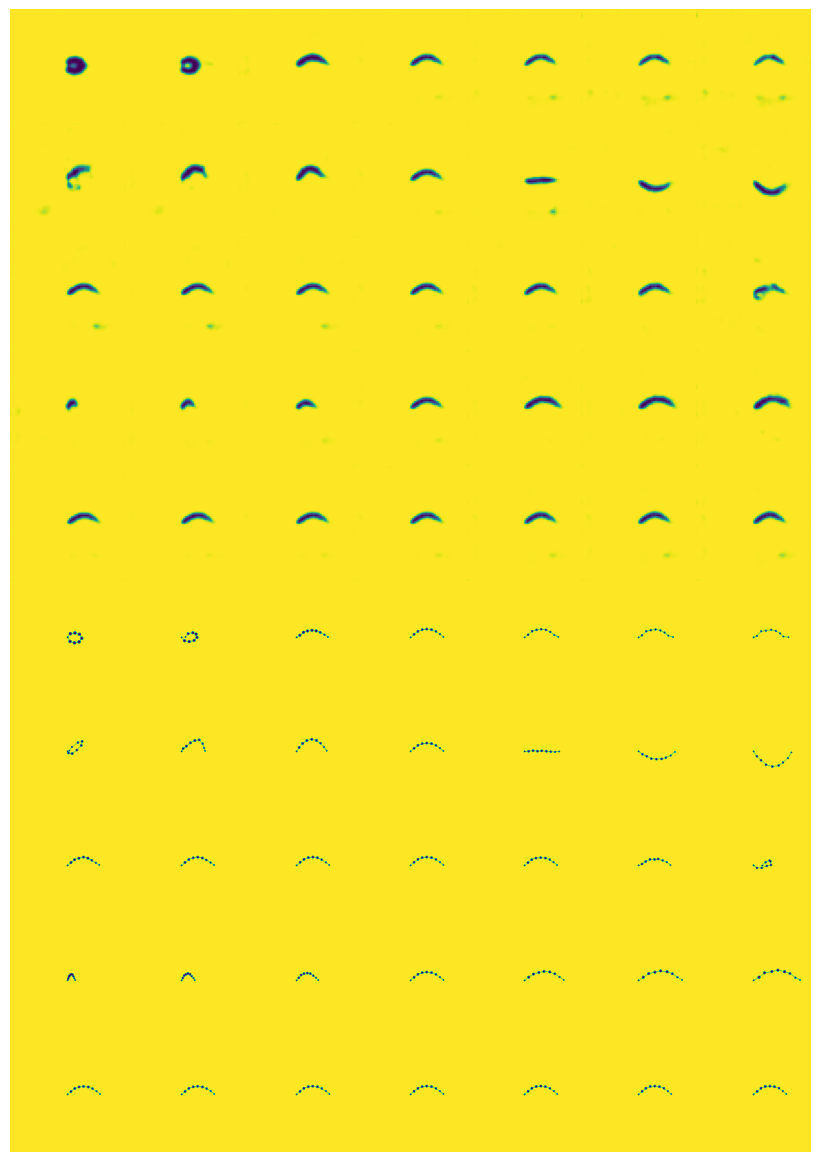

In [11]:
# Varying different latent variables at a time
def vary_one_at_a_time(idx):
    rs = resize64(strokes)
    s = rs[idx].unsqueeze(0).unsqueeze(0).to(device)
    t = trajectories[idx].unsqueeze(0).to(device)
    enc, _ = model.encode(s, t)
    s_data = []
    t_data = []
    for i in range(5):
        s_data_row = []
        t_data_row = []
        for j in range(-3, 4):
            shift = torch.zeros(5)
            shift[i] += j
            shift = shift.to(device)
            shifted = enc + shift
            stroke, trajectory = model.decode(shifted)
            stroke = stroke.cpu().detach().reshape((64, 64))
            trajectory = tv.visualize_trajectory(trajectory.cpu().detach().squeeze(0))
            s_data_row.append(stroke)
            t_data_row.append(trajectory)
        s_data.append(s_data_row)
        t_data.append(t_data_row)
    data = s_data + t_data
    no_gap_plot(data)
vary_one_at_a_time(1)